# MRP with Age and "Which quality is more important for children: obedience vs. self-reliance?"

In [1]:
%matplotlib inline

from misc import *

from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib
from scipy.special import logit
from theano import shared
from itertools import product

import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load the survey data
index1 = preprocess(pd.read_excel('data/RawData/IN10001.xls'))
index4 = preprocess(pd.read_excel('data/RawData/IN10004.xls'))
index5 = preprocess(pd.read_excel('data/RawData/IN10005.xls'))
index6 = preprocess(pd.read_excel('data/RawData/IN10006.xls'))
index7 = preprocess(pd.read_excel('data/RawData/IN10007.xls'))

# Create a new dataframe that only contains the demographic information that's included in each survey

# Note: Changed this to index6 from index7
common_columns = list(set(index1.columns).intersection(set(index6.columns)))
common_data = pd.concat([index1[common_columns],
                         index4[common_columns],
                         index5[common_columns],
                         index6[common_columns],
                         index7[common_columns]])

# Drop the columns that don't contain demographic information
common_data.drop(['ID', 'ADID IDFA', 'Time Started', 'Time Finished'], axis=1, inplace=True)

# Drop the columns where area is missing since the distributions for each demographic doesn't differ much
index6 = index6[index6.Area != 'Unknown']
common_data = common_data.loc[common_data['Area'] != 'Unknown', :]

In [3]:
# Encode demographic columns and create marginal demographic columns using an overall dataset
def encode_demo(index, common):
    # Create separate LabelEncoder instances for each variable
    age_enc = LabelEncoder()
    
    # Enumerate the possible values for each variable using the overall dataset
    age_list = common['Age'].unique()
    
    # Fit each LabelEncoder instance to its respective list of values
    age_enc.fit(age_list)
    
    # Encode the individual categories as integers
    index['Age Encoded'] = age_enc.transform(index['Age'])

    return index

# Perform one hot encoding on the possible answers for any given question
def ohe_question(index, question):
#     col_name = ' '.join(question.split(' ')[:4])
#     index = pd.concat([index,
#                        pd.get_dummies(index[question],
#                                       prefix=col_name,
#                                       prefix_sep='|')],
#                       axis=1)
    question_col = index[question]
    dummy_cols = pd.get_dummies(question_col, prefix='More Important Quality', prefix_sep='|')
    index.drop(question, axis=1, inplace=True)
    new_df = pd.concat([index, dummy_cols], axis=1)
    return new_df

In [4]:
index6 = encode_demo(index6, common_data)
common_data_encoded = encode_demo(common_data, common_data)
common_data_encoded.head()

,City,Socialite,Area,Income,Number of children,What is your political party affiliation?,Productivity Booster,Provider,Job Seeker,DMA Name,...,Fashionista,Bookworm,Marital Status,Entertainment Enthusiast,Car Purchase,Traveler,Education,OS,Insurance,Age Encoded
0,Minneapolis,True,Minnesota,lower_ii,zero,Independent,False,Verizon Wireless,NaN,Minneapolis-St. Paul,...,True,True,married,True,NaN,True,no bachelors,Android,NaN,1
2,Beaumont,NaN,Texas,high_i,three,Republican,NaN,NaN,NaN,Beaumont-Port Arthur,...,NaN,NaN,married,NaN,NaN,NaN,bachelors,Web,NaN,4
3,Ilion,True,New York,lower_ii,two,Democrat,False,00000,NaN,Utica,...,True,True,single,True,NaN,False,no bachelors,Android,NaN,0
4,Washington,NaN,District of Columbia,lower_i,one,Republican,NaN,Sprint,NaN,"Washington, Dc (Hagrstwn)",...,NaN,NaN,single,NaN,NaN,NaN,no bachelors,iOS,NaN,2
5,Unknown,True,Texas,lower_ii,five,Independent,False,AT&T,NaN,NaN,...,False,True,married,True,NaN,False,no bachelors,Android,NaN,2


In [5]:
question = 'Which quality is more important for children: obedience vs. self-reliance?'
index6 = ohe_question(index6, question)

In [6]:
index6.head()

,ID,Time Started,Time Finished,OS,Area,City,Provider,Gender,Age,Year Of Birth,...,Fashionista,Job Seeker,Insurance,Real Estate,Car Purchase,ADID IDFA,Age Encoded,More Important Quality|Don't know,More Important Quality|Obedience,More Important Quality|Self-reliance
0,1093256017,2018-01-27 16:24:41,2018-01-27 16:28:42,Android,Illinois,Centralia,Verizon Wireless,male,25 - 34,1988,...,True,NaN,NaN,NaN,NaN,79041a10-1815-4c98-b993-53ed9e63adbc,1,0,0,1
1,42384573,2018-01-27 16:26:03,2018-01-27 16:28:22,Android,California,Rialto,MetroPCS,male,45 - 54,1973,...,False,NaN,NaN,NaN,NaN,ca91af1e-5c2e-4501-9319-97f9e3b16cb6,3,0,0,1
2,999822156,2018-01-27 16:26:51,2018-01-27 16:28:17,Android,Pennsylvania,Pittsburgh,NaN,male,18 - 24,1999,...,False,NaN,NaN,NaN,NaN,NaN,0,1,0,0
3,-1522889414,2018-01-27 16:27:04,2018-01-27 16:28:13,Android,Georgia,Atlanta,T-Mobile,male,18 - 24,1996,...,False,NaN,NaN,NaN,NaN,a5b35608-4e65-4ec4-9551-8aa06033e56f,0,0,0,1
4,-299564538,2018-01-27 16:23:44,2018-01-27 16:28:05,Android,Pennsylvania,Unknown,Verizon Wireless,male,45 - 54,1966,...,True,NaN,NaN,NaN,NaN,ea51c835-62c0-4078-b3bc-f1ddd01bf003,3,0,1,0


In [7]:
question_response = "More Important Quality|Don't know"
results_name = 'dont-know'

In [8]:
# Group by age to see how many are in each cell and how many in each cell will vote
index6_unique = index6.groupby(['Age Encoded'])[question_response]
index6_unique = index6_unique.agg([(question_response, 'sum'), ('n', 'size')]).reset_index()

In [9]:
index6_unique.head()

,Age Encoded,More Important Quality|Don't know,n
0,0,12,181
1,1,19,374
2,2,9,235
3,3,6,164
4,4,4,177


In [10]:
# Create Theano constant variables for the demographic and marginal demographic variables
age_theano = shared(index6_unique['Age Encoded'].values)

# Create a Theano constant variable for the number of observations in each population cell
n_theano = shared(index6_unique['n'].values)

In [11]:
# Define the model for the state-level effects coefficient
def hierarchical_normal(name, shape, mu=0.0):
    delta = pm.Normal('delta_{}'.format(name), 0.0, 1.0, shape=shape)
    sigma = pm.HalfCauchy('sigma_{}'.format(name), 5.0) 
    return pm.Deterministic(name, mu + delta*sigma)

In [12]:
"""
This section creates the general population variables.
======================================================

The intercept beta_0 uses an initial value for sampling that's equal to
the log odds of a respondent voting based on the survey responses.

Each of the general population demographic and marginal demographic
variables have a mean of 0 and a standard deviation of delta*sigma,
where delta is sampled from a normal distribution with a mean of 0
and standard deviation of 1, and sigma is sampled from a
half Cauchy distribution with beta = 5.

The variable eta is the multilevel logistic regression model that models
the log odds of the voter turnout rate.

"""

with pm.Model() as model:
    beta_0 = pm.Normal('beta_0', 0.0, 5.0)
    alpha_age = hierarchical_normal(name='age', shape=common_data['Age'].unique().size)
    eta = (beta_0 + alpha_age[age_theano])

In [13]:
# Define the observed random variables using a binomial distribution with a probability equal to eta
with model:
    p = pm.math.sigmoid(eta)
    obs = pm.Binomial('obs', n_theano, p, observed=index6_unique[question_response].values)

In [14]:
# Sample the model using 'map' as the initialization method for the NUTS sampler
with model:
    trace = pm.sample(draws=1000,
                      tune=1000,
                      nuts_kwargs={'target_accept': 0.99},
                      init='advi+adapt_diag',
                      njobs=10)

joblib.dump(trace, 'trace_age.pkl')
print(max(np.max(score) for score in pm.gelman_rubin(trace).values()))

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 29.823:   5%|▌         | 10240/200000 [00:07<02:25, 1301.05it/s]
Convergence archived at 10300
Interrupted at 10,299 [5%]: Average Loss = 268.96
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_age_log__, delta_age, beta_0]
100%|██████████| 2000/2000 [00:51<00:00, 38.54it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


1.0033960552245296


/Library/Python/2.7/site-packages/matplotlib-override/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


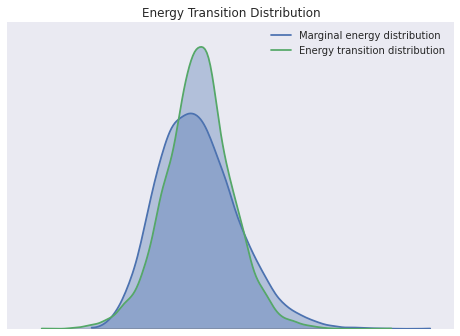

In [15]:
pm.energyplot(trace)
plt.title('Energy Transition Distribution')
plt.show()

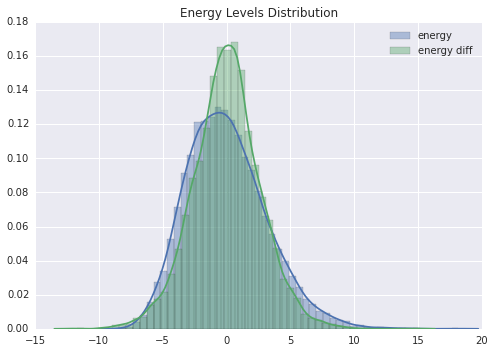

In [16]:
# Compare the distribution of energy levels to the distribution of changes in energy levels between samples
energy = trace['energy']
energy_diff = np.diff(energy)
sb.distplot(energy - energy.mean(), label='energy')
sb.distplot(energy_diff, label='energy diff')
plt.title('Energy Levels Distribution')
plt.legend()
plt.show()

Number of Divergent 1
Percentage of Divergent 0.00000


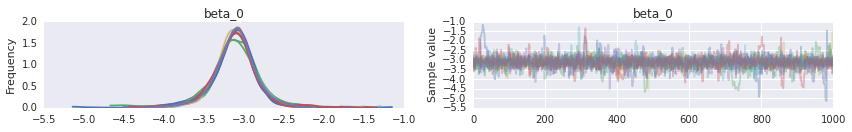

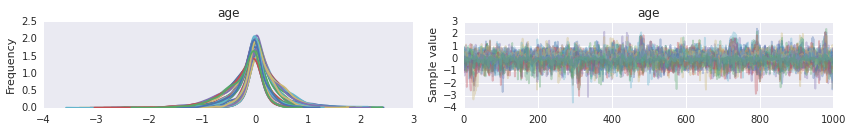

In [17]:
# Display the trace plot and density plot for each variable
model_vars = [beta_0, alpha_age]

for var in model_vars:
    pm.traceplot(trace, varnames=[var])
    
# Display the total number and percentage of divergent transitions
divergent = trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(trace)
print('Percentage of Divergent %.5f' % divperc)

100%|██████████| 1000/1000 [00:00<00:00, 2340.90it/s]


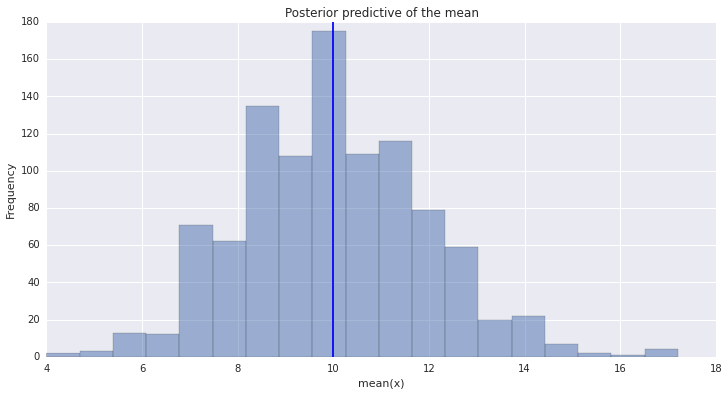

In [18]:
# Perform a posterior predictive check to ensure that the sample distribution overlaps with the dataset mean
ppc = pm.sample_ppc(trace, samples=1000, model=model)

_, ax = plt.subplots(figsize=(12, 6))
ax.hist([k.mean() for k in ppc['obs']], bins=19, alpha=0.5)
ax.axvline(index6_unique[question_response].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

In [19]:
# Load 2016 Census Bureau state/gender/age data
# https://www2.census.gov/programs-surveys/popest/datasets/2010-2016/state/asrh/sc-est2016-agesex-civ.csv
census = pd.read_csv('demographics/sc-est2016-agesex-civ.csv')

census = census.drop(['SUMLEV', 'REGION', 'DIVISION', 'STATE',
                      'ESTBASE2010_CIV', 'POPEST2010_CIV', 'POPEST2011_CIV', 'POPEST2012_CIV',
                      'POPEST2013_CIV', 'POPEST2014_CIV', 'POPEST2015_CIV'], axis=1)

# Remove national level and child population counts
census = census.loc[census['NAME'] == 'United States']
census = census.loc[census['AGE'] >= 18]
census = census.loc[census['AGE'] != 999]

In [20]:
# Sum population counts based on the survey data age ranges
age_tuples = [(18, 24), (25, 34), (35, 44), (45, 54), (55, 85)]
age_ranges = ['18 - 24', '25 - 34', '35 - 44', '45 - 54', '> 54']
counts = []

for marginal in product(census['NAME'].unique(), age_tuples):
    counts.append((marginal[1],
                   census.loc[(census['AGE'] >= marginal[1][0]) &
                              (census['AGE'] <= marginal[1][1])]['POPEST2016_CIV'].sum()))

# Rename column names and age ranges to match the survey data
state_age = pd.DataFrame.from_records(counts, columns=['Age', 'n'])

for age_range in zip(age_tuples, age_ranges):
    state_age.loc[state_age['Age'] == age_range[0], 'Age'] = age_range[1]
    
# Merge the state-level data with the Census data to perform poststratification

# ps_df = pd.merge(state_df, state_age, on='Area')
ps_df = state_age.copy()

In [21]:
# Encode the age ranges into integers
age_enc = LabelEncoder()
ps_df['Age Encoded'] = age_enc.fit_transform(ps_df['Age'])

In [22]:
# Set the previously defined Theano variables to the poststratification values
age_theano.set_value(ps_df['Age Encoded'].values)
n_theano.set_value(ps_df['n'].values)

100%|██████████| 1000/1000 [00:00<00:00, 2747.33it/s]


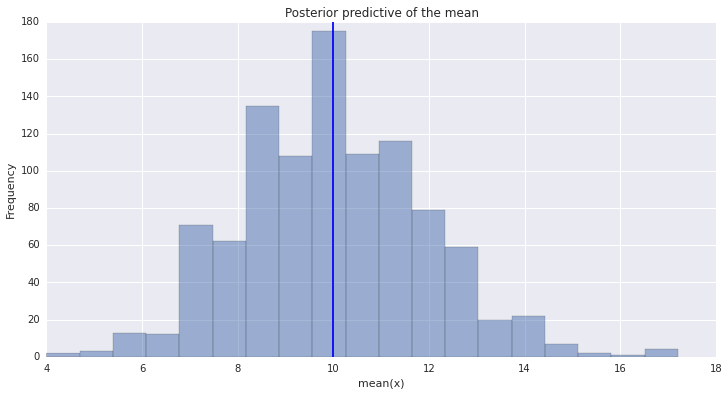

In [23]:
# Draw a new sample from the posterior predictive distribution
ps_ppc = pm.sample_ppc(trace, samples=1000, model=model)

_, ax = plt.subplots(figsize=(12, 6))
ax.hist([k.mean() for k in ppc['obs']], bins=19, alpha=0.5)
ax.axvline(index6_unique[question_response].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

In [24]:
# Merge the state-level data with the posterior distribution sample

PP_COLS = ['DK_{}'.format(i) for i in range(ps_ppc['obs'].shape[0])]
ppc_df = pd.merge(ps_df, pd.DataFrame(ps_ppc['obs'].T, columns=PP_COLS),
                  left_index=True, right_index=True)

# Calcuate the average probability of each demographic answering "Obedience" over all samples

#cell_prob_obedience = ppc_df.groupby(['Age']).apply(lambda df: df[PP_COLS].mean(axis=1)/df['n'])
cell_prob = ppc_df.groupby(['Age']).apply(lambda df: df[PP_COLS].mean(axis=1)/df['n'])

# #Calculate a weighted average to obtain the probability of respodents in each state answering "Obedience"

# area_prob = ppc_df.groupby(['Area']).apply(lambda df: df[PP_COLS].mean(axis=0)/df['n'].sum()).mean(axis=1)

In [25]:
cell_prob

Age       
18 - 24  0    0.052463
25 - 34  1    0.047520
35 - 44  2    0.041479
45 - 54  3    0.040625
> 54     4    0.035617
dtype: float64

In [26]:
pd.DataFrame(cell_prob).to_csv('results_'+results_name+'.csv')